In [1]:
# please check the data folder for the dataset

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime
import os
import config


In [2]:
def get_data():
    url = "https://corona-virus-world-and-india-data.p.rapidapi.com/api_india"
    
    api_key = config.api_key
    headers = {
        'x-rapidapi-key': api_key,
        'x-rapidapi-host': "corona-virus-world-and-india-data.p.rapidapi.com"
        }

    response = requests.request("GET", url, headers=headers)

    response = response.json()
    
    return response

In [3]:
states = ["Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar", "Chhattisgarh","Gujarat", "Haryana", "Himachal Pradesh",
"Jharkhand", "Karnataka", "Kerala",
"Madhya Pradesh",
"Maharashtra",
"Manipur",
"Meghalaya",
"Mizoram",
"Nagaland",
"Odisha",
"Punjab",
"Rajasthan",
"Sikkim",
"Tamil Nadu",
"Telangana",
"Tripura",
"Uttar Pradesh",
"Uttarakhand",
"West Bengal"]


In [4]:

def preprocess_data(response):

    data = []
    state_data = {}
    total_states = []
    district_state_wise = []
    updated_time = []

    for state in states:
        districts = response['state_wise'][state]['district']

        for district_name, district_data in districts.items():
            state_data[state] = [district_name]
            total_states.append(state)
            district_state_wise.append(district_name)

            active_cases = district_data['active']
            confirmed_cases = district_data['confirmed']
            deceased_cases = district_data['deceased']
            recovered_cases = district_data['recovered']
            data.append([active_cases, confirmed_cases, deceased_cases, recovered_cases])
            updated_time.append(response['state_wise'][state]['lastupdatedtime'])

        if state_data[state]:
            state_data[state] = district_state_wise
        
    return data, state_data, total_states, district_state_wise, updated_time


def create_dataframe(response):
    
    data, state_data, total_states, district_state_wise, updated_time = preprocess_data(response)
    
    df = pd.DataFrame(data, columns=['active', 'confirmed', 'deceased', 'recovered'])
    df.insert(0, "states", total_states)
    df.insert(1, "districts", district_state_wise)
    df.insert(6, 'last_updated', updated_time)
    
    df['last_updated'] = df['last_updated'].str.split(" ")[0][0]
    df['last_updated'] = pd.to_datetime(df['last_updated'], format='%d/%m/%Y')
    
    return df
    

In [5]:
response = get_data()
dataset = create_dataframe(response)

In [6]:
dataset.head()

,states,districts,active,confirmed,deceased,recovered,last_updated
0,Andhra Pradesh,Foreign Evacuees,0,434,0,434,2021-02-16
1,Andhra Pradesh,Anantapur,21,67698,599,67078,2021-02-16
2,Andhra Pradesh,Chittoor,97,87229,847,86285,2021-02-16
3,Andhra Pradesh,East Godavari,77,124369,636,123656,2021-02-16
4,Andhra Pradesh,Guntur,43,75627,671,74913,2021-02-16


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   states        717 non-null    object        
 1   districts     717 non-null    object        
 2   active        717 non-null    int64         
 3   confirmed     717 non-null    int64         
 4   deceased      717 non-null    int64         
 5   recovered     717 non-null    int64         
 6   last_updated  717 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 39.3+ KB


In [8]:
dataset.shape

(717, 7)

In [ ]:
df.to_csv('covid_district_wise_version_1.csv', index=False)

In [ ]:
df_1 = pd.read_csv('covid_district_wise_version_1.csv')
df_1.head()

# Covid data based on dates

In [56]:
import requests
import pandas as pd
import config

def get_data_by_timeline():
    url = "https://corona-virus-world-and-india-data.p.rapidapi.com/api_india_timeline"
    
    api_key = config.api_key
    headers = {
        'x-rapidapi-key': api_key,
        'x-rapidapi-host': "corona-virus-world-and-india-data.p.rapidapi.com"
        }

    response = requests.request("GET", url, headers=headers)

    timeline_data = response.json()
    return timeline_data


def calculate_death_ratio(df):
    if df[2] == 0:
        return 0
    else:
        deceased_ratio = df[2]/(df[0] + df[1])
        
    return round(deceased_ratio, 3)


def process_covid_by_timeline():
    response = get_data_by_timeline()
    dates = []
    daily_confirmed = []
    daily_deceased = []
    daily_recovered = []

    for count in range(len(response)):
        dates.append(response[count]['dateymd'])
        daily_confirmed.append(response[count]['dailyconfirmed'])
        daily_deceased.append(response[count]['dailydeceased'])
        daily_recovered.append(response[count]['dailyrecovered'])
        
    covid_dataset_by_dates = pd.DataFrame(list(zip(dates, daily_confirmed, daily_deceased, daily_recovered)), 
            columns=['dates', 'confirmed', 'deceased', 'recovered'])
    
    covid_dataset_by_dates['confirmed'] = covid_dataset_by_dates['confirmed'].astype('int')
    covid_dataset_by_dates['deceased'] = covid_dataset_by_dates['deceased'].astype('int')
    covid_dataset_by_dates['recovered'] = covid_dataset_by_dates['recovered'].astype('int')
        
    covid_dataset_by_dates['dates'] = pd.to_datetime(covid_dataset_by_dates['dates'], format='%Y-%m-%d')
    
    covid_dataset_by_dates['death_ratio'] = covid_dataset_by_dates[['confirmed', 'recovered', 'deceased']].apply(calculate_death_ratio, axis=1)    
    
    return covid_dataset_by_dates



In [57]:
covid_dataset_by_dates = process_covid_by_timeline()

In [29]:
covid_dataset_by_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dates        384 non-null    datetime64[ns]
 1   confirmed    384 non-null    int32         
 2   deceased     384 non-null    int32         
 3   recovered    384 non-null    int32         
 4   death_ratio  384 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int32(3)
memory usage: 10.6 KB


In [30]:
covid_dataset_by_dates.isnull().sum()

dates          0
confirmed      0
deceased       0
recovered      0
death_ratio    0
dtype: int64

In [31]:
covid_dataset_by_dates.shape

(384, 5)

In [ ]:
#we have to ignore month for now because the value remains the same for 2020 and 2021.

#covid_dataset_by_dates['month'] = covid_dataset_by_dates['dates'].apply(lambda x: x.month)
#covid_dataset_by_dates.head()

In [ ]:
covid_dataset_by_dates.to_csv(r'C:\Users\Abhiram Challapalli\Desktop\Ineuron Projects\ml_healthcare\Data\covid_dataset_by_dates.csv')

## EDA

In [ ]:
dataset.head()

In [22]:
by_state = pd.pivot_table(dataset, index='states', values=['active', 'confirmed', 'deceased', 'recovered'], aggfunc='sum')
by_state

,active,confirmed,deceased,recovered
states,,,,
Andhra Pradesh,615,888959,7163,881181
Arunachal Pradesh,3,16833,56,16774
Assam,209,217309,1089,214615
Bihar,564,261841,1528,259748
Chhattisgarh,2905,309623,3783,302935
Gujarat,1699,265756,4402,259655
Haryana,819,269240,3040,265381
Himachal Pradesh,398,58243,981,56851
Jharkhand,460,119394,1084,117850


In [17]:
by_state['active'].min(), by_state['confirmed'].max()

(2, 2071306)

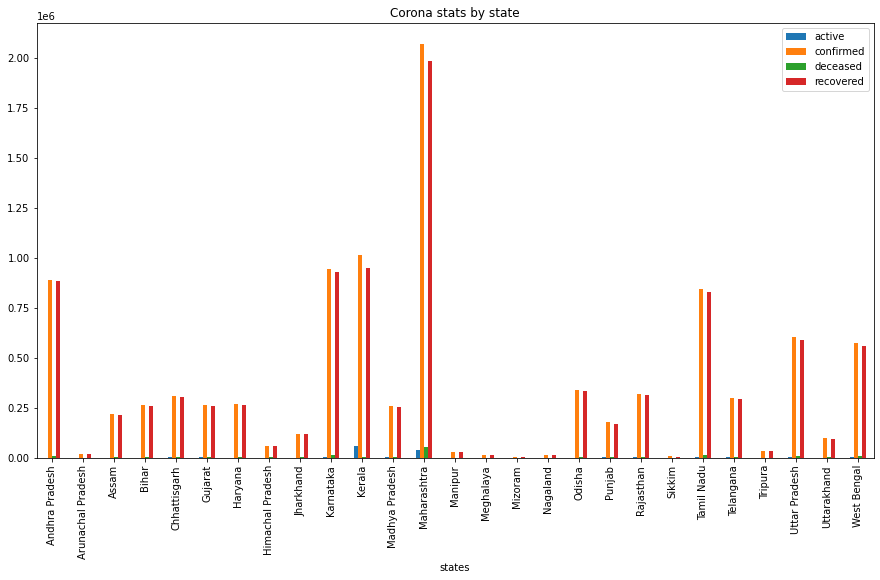

In [23]:
plt.rcParams["figure.figsize"] = [15, 8]
by_state.reset_index().plot(x='states', y=['active', 'confirmed', 'deceased', 'recovered'],kind='bar')
plt.title("Corona stats by state")
#plt.ylim(2,2071306)
plt.show()

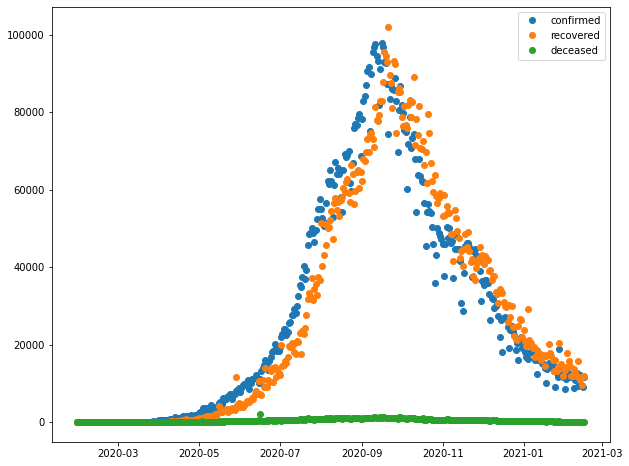

In [24]:
dates = matplotlib.dates.date2num(covid_dataset_by_dates['dates'])

plt.figure(figsize=(10,8))
plt.plot_date(dates, covid_dataset_by_dates['confirmed'], label='confirmed')
plt.plot_date(dates, covid_dataset_by_dates['recovered'], label='recovered')
plt.plot_date(dates, covid_dataset_by_dates['deceased'], label='deceased')

plt.legend()
plt.show()

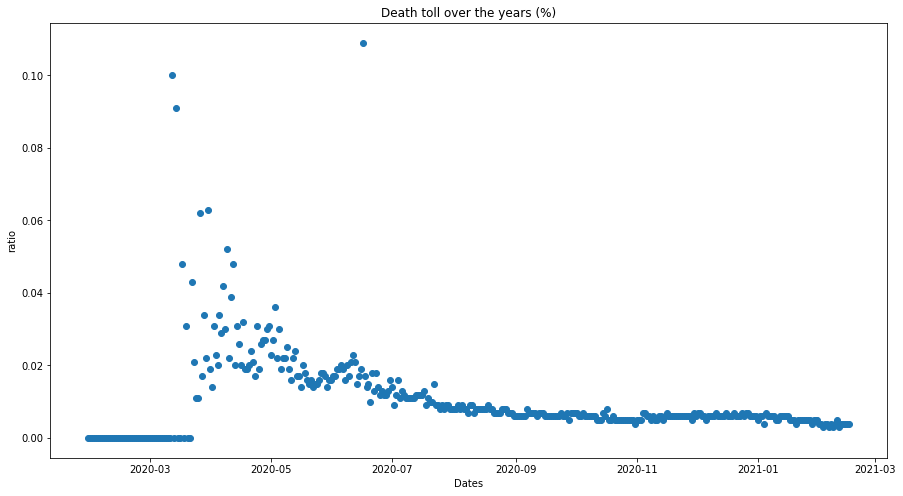

In [58]:
#covid_dataset_by_dates['death_ratio'].plot()
plt.plot_date(dates, covid_dataset_by_dates['death_ratio'])
plt.title("Death toll over the years (%)")
plt.xlabel("Dates")
plt.ylabel("ratio")
plt.show()

## Testing few things

In [26]:
import requests

url = "https://coronavirus-map.p.rapidapi.com/v1/spots/week"

querystring = {"region":"india"}

headers = {
    'x-rapidapi-key': "6b9a040689msh4c3e22ad300cc1fp19b019jsn8ea1698972ba",
    'x-rapidapi-host': "coronavirus-map.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)
response = response.json()

In [27]:
response

{'status': 200,
 'type': 'stack',
 'data': {'2021-02-17': {'total_cases': 10949546,
   'deaths': 156038,
   'recovered': 10654706,
   'critical': 8944,
   'tested': 207977229,
   'death_ratio': 0.014250636510408742,
   'recovery_ratio': 0.9730728561713883},
  '2021-02-16': {'total_cases': 10937106,
   'deaths': 155949,
   'recovered': 10642903,
   'critical': 8944,
   'tested': 207332298,
   'death_ratio': 0.014258707925112914,
   'recovery_ratio': 0.9731004710021097},
  '2021-02-15': {'total_cases': 10925208,
   'deaths': 155836,
   'recovered': 10630779,
   'critical': 8944,
   'tested': 206230512,
   'death_ratio': 0.01426389319086648,
   'recovery_ratio': 0.97305049020577},
  '2021-02-14': {'total_cases': 10904940,
   'deaths': 155673,
   'recovered': 10611731,
   'critical': 8944,
   'tested': 206230512,
   'death_ratio': 0.014275456811316705,
   'recovery_ratio': 0.973112277554943},
  '2021-02-13': {'total_cases': 10904738,
   'deaths': 155673,
   'recovered': 10609788,
   'criti

In [24]:
covid_dataset_by_dates

,dates,confirmed,deceased,recovered
0,2020-01-30,1,0,0
1,2020-01-31,0,0,0
2,2020-02-01,0,0,0
3,2020-02-02,1,0,0
4,2020-02-03,1,0,0
...,...,...,...,...
379,2021-02-12,12137,104,11358
380,2021-02-13,12191,89,11107
381,2021-02-14,11706,91,9500
382,2021-02-15,9086,82,11793
